In [1]:
from sim import *
from read_ramses import *
from functions import *
import const

from colossus.cosmology import cosmology
from colossus.lss import peaks
cosmo = cosmology.setCosmology('planck18');


### Poisson

In [5]:
prob = 0.5 # order unity probability
avg = 0.0001 # expected value of the poisson distribution
ntstep = -np.log(1 - prob) / avg # expected number of timesteps until nonzero number of star particles
tstep = 500 * const.yr

print(ntstep)
print(ntstep * tstep / const.Myr)

6931.471805599453
3.4657359027997265


### star formation

In [2]:
# choose simulation
sim_round = 3
sim_name = "gas"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]

cool_tab = get_cool_tab(n3=100)

Moving to directory '/home/za9132/scratch/romain/round3/gas'.


In [3]:
# set resolution and constants
boxsize = 100 * const.Mpc
L_max = 23
dx = boxsize / 2**L_max
gamma = 5/3


Text(0.5, 1.0, '$Z = Z_{\\odot}$')

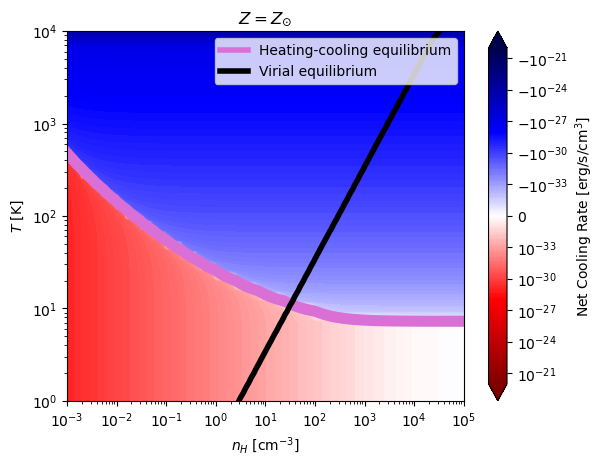

In [4]:
C = 1e-36
bound = 1e-20
Z = 1e-3 * const.Z_sol

boxsize = 100 * const.Mpc
L_max = 23
dx = boxsize / 2**L_max
gamma = 5/3
alpha_vir = 15 / np.pi * gamma * const.k_B * cool_tab.temp[:, None] / (const.G * cool_tab.n_H[None, :] * (cool_tab.mu * const.m_p * dx)**2)

net_cool = cool_tab.cool + cool_tab.cool_com + cool_tab.metal * Z / const.Z_sol - cool_tab.heat - cool_tab.heat_com
im = plt.contourf(cool_tab.n_H, cool_tab.temp, symlog(net_cool, C=C), levels=np.linspace(symlog(-bound, C=C), symlog(bound, C=C), 200), cmap='seismic_r', extend='both')
cs = plt.contour(cool_tab.n_H, cool_tab.temp, net_cool, levels=[0], colors='orchid', linewidths=8)
plt.contour(cool_tab.n_H, cool_tab.temp, alpha_vir, levels=[1], colors='black', linewidths=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]')
plt.ylabel(r'$T$ [${\rm K}$]')

skip = 3
cbar_ticks_temp = 10**np.arange(np.log10(C), np.log10(bound))[skip:]
cbar_ticks = symlog(np.concatenate((-cbar_ticks_temp[::skip][::-1], [0], cbar_ticks_temp[::skip])), C=C)
cbar = plt.colorbar(im, label=r'Net Cooling Rate [${\rm erg/s/cm^3}$]', ticks=cbar_ticks)
cbar_ticklabels = [r'$10^{%d}$' % exp for exp in np.log10(cbar_ticks_temp)][::skip][::-1] + [0] + [r'$-10^{%d}$' % exp for exp in np.log10(cbar_ticks_temp)][::skip]
cbar.ax.set_yticklabels(cbar_ticklabels)

plt.xlim(1e-3, 1e5)
plt.ylim(1e0, 1e4)

custom_lines = [Line2D([0], [0], color='orchid', lw=4), Line2D([0], [0], color='black', lw=4)]
plt.gca().legend(custom_lines, [r'Heating-cooling equilibrium', 'Virial equilibrium'])

plt.title(r'$Z = Z_{\odot}$')

#save_fig('heatcool-Z1')


In [210]:
temp_eq_cool = np.zeros((cool_tab.Z.size, cool_tab.n_H.size))
temp_eq_cool_Z0 = np.zeros((cool_tab.n_H.size))

for i, Z in enumerate(cool_tab.Z):
    for j, n_H in enumerate(cool_tab.n_H):
        cool = cool_tab.cool[:, j] + cool_tab.cool_com[:, j]
        heat = cool_tab.heat[:, j] + cool_tab.heat_com[:, j]
        metal = cool_tab.metal[:, j] * Z / const.Z_sol
        coolheat_interp = interp1d(np.log10(cool_tab.temp), np.log10(cool + metal) - np.log10(heat), kind='linear', fill_value="extrapolate")
        temp_eq_cool[i, j] = 10**fsolve(coolheat_interp, 4)[0]
        
for j, n_H in enumerate(cool_tab.n_H):
    cool = cool_tab.cool[:, j] + cool_tab.cool_com[:, j]
    heat = cool_tab.heat[:, j] + cool_tab.heat_com[:,j]
    coolheat_interp = interp1d(np.log10(cool_tab.temp), np.log10(cool) - np.log10(heat), kind='linear', fill_value="extrapolate")
    temp_eq_cool_Z0[j] = 10**fsolve(coolheat_interp, 4)[0]
        

In [211]:
temp_eq_virial = np.zeros((cool_tab.n_H.size))
        
for j, n_H in enumerate(cool_tab.n_H):
    virial_interp = interp1d(np.log10(cool_tab.temp), np.log10(cool_tab.temp) - np.log10(15 / np.pi * const.G * n_H * (cool_tab.mu[:, j] * const.m_p * dx)**2 / (gamma * const.k_B)), kind='linear', fill_value="extrapolate")
    temp_eq_virial[j] = 10**fsolve(virial_interp, 4)[0]


Saved figure as 'equilibrium-120520231753.png'


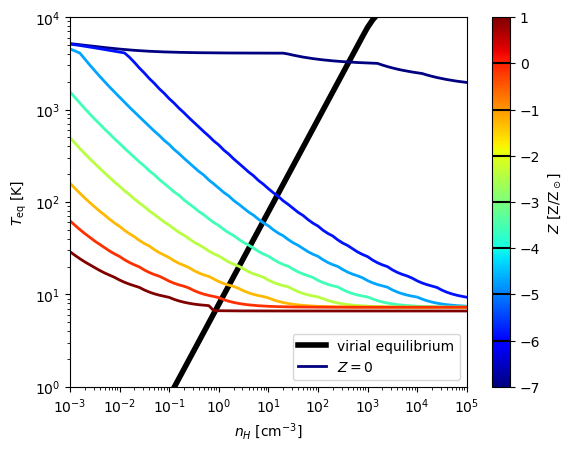

In [294]:
#temp_eq_virial = 15 / np.pi * const.G * cool_tab.n_H * (const.m_p * dx)**2 / (gamma * const.k_B)
plt.plot(cool_tab.n_H, temp_eq_virial, color='black', lw=4, label='virial equilibrium')

cbar_norm = mpl.colors.Normalize(vmin=-7, vmax=1, clip=True)
sm = mpl.cm.ScalarMappable(cmap='jet', norm=cbar_norm)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$Z$ [${\rm Z / Z_\odot}$]')

list_of_Z = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]) * const.Z_sol
colors = mpl.cm.jet(np.linspace(0, 1, list_of_Z.size + 1))
plt.plot(cool_tab.n_H, temp_eq_cool_Z0, lw=2, color=colors[0], label=r'$Z = 0$')
for i, Z in enumerate(list_of_Z):
    idx = np.argmin(np.abs(cool_tab.Z - Z))
    plt.plot(cool_tab.n_H, temp_eq_cool[idx], lw=2, color=colors[i + 1])
    cbar.ax.axhline(y=np.log10(Z / const.Z_sol), color='black')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]')
plt.ylabel(r'$T_{\rm eq}$ [${\rm K}$]')

plt.xlim(1e-3, 1e5)
plt.ylim(1e0, 1e4)

plt.legend()

save_fig('equilibrium')


Saved figure as 'metal-dependence-120520231754.png'


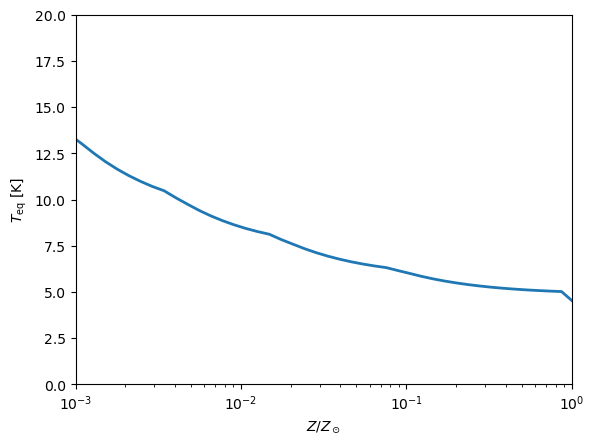

In [300]:
temp_eq = np.zeros((cool_tab.Z.size))
temp_eq2 = np.zeros((cool_tab.Z.size))

# log_temp_eq_virial_interp = lambda log_n_H: np.log10(15 / np.pi * const.G * 10**log_n_H * (const.m_p * dx)**2 / (gamma * const.k_B))
log_temp_eq_virial_interp = interp1d(np.log10(cool_tab.n_H), np.log10(temp_eq_virial), kind='linear', fill_value="extrapolate")

for i, Z in enumerate(cool_tab.Z):
    log_temp_eq_cool_interp = interp1d(np.log10(cool_tab.n_H), np.log10(temp_eq_cool[i]), kind='linear', fill_value="extrapolate")
    log_n_H_eq = fsolve(lambda log_n_H: log_temp_eq_virial_interp(log_n_H) - log_temp_eq_cool_interp(log_n_H), x0=1)[0]
    temp_eq[i] = 10**log_temp_eq_virial_func(log_n_H_eq)

plt.plot(cool_tab.Z / const.Z_sol, temp_eq, lw=2)

plt.xscale('log')
#plt.yscale('log')

plt.xlim(1e-3, 1e0)
plt.ylim(0, 20)

plt.xlabel(r'$Z / Z_\odot$')
plt.ylabel(r'$T_{\rm eq}$ [${\rm K}$]')

save_fig('metal-dependence')


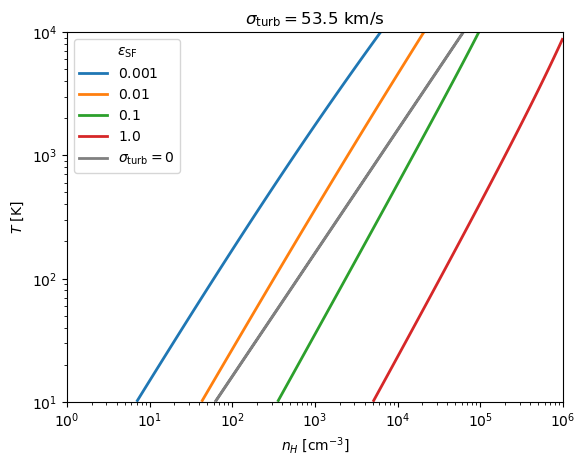

In [5]:
num = 1000
temp_eq = 100
dx = 10 * const.pc
b_turb = 1.0
vel_turb = 53.47 * const.km

n_H_extrema = (1e0, 1e6)
temp_extrema = (1e1, 1e4)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
temp_1d = np.logspace(*np.log10(temp_extrema), num)
n_H, temp = np.meshgrid(n_H_1d, temp_1d, indexing='ij')
rho = n_H * const.m_p

epsilon_SF_nodisp = calc_epsilon_SF(rho, 1e-5 * const.km, temp_eq=temp, dx=dx, b_turb=b_turb)
epsilon_SF = calc_epsilon_SF(rho, vel_turb, temp_eq=temp, dx=dx, b_turb=b_turb)

plt.contour(n_H, temp, epsilon_SF_nodisp, levels=[1e0], colors='grey', linewidths=2, linestyles='-')
cs = plt.contour(n_H, temp, epsilon_SF, levels=[1e-3, 1e-2, 1e-1, 1e0], colors=['C0', 'C1', 'C2', 'C3'], linewidths=2, linestyles='-')
    
plt.ylabel(r"$T$ [${\rm K}$]")
plt.xlabel(r"$n_H$ [${\rm cm^{-3}}$]")

plt.xscale('log')
plt.yscale('log')

plt.title(r'$\sigma_{\rm turb} = %.3g~{\rm km/s}$' % (vel_turb / const.km))

custom_lines = [Line2D([0], [0], color='C0', lw=2), Line2D([0], [0], color='C1', lw=2), Line2D([0], [0], color='C2', lw=2), Line2D([0], [0], color='C3', lw=2), Line2D([0], [0], color='grey', lw=2)]
plt.legend(custom_lines, [r'$0.001$', r'$0.01$', r'$0.1$', r'$1.0$', r'$\sigma_{\rm turb} = 0$'], title=r'$\varepsilon_{\rm SF}$', loc=2)

# save_fig('epsilon_SF_vel_avg')


Saved figure as 'epssf-bturb0p3-012920241715.png'


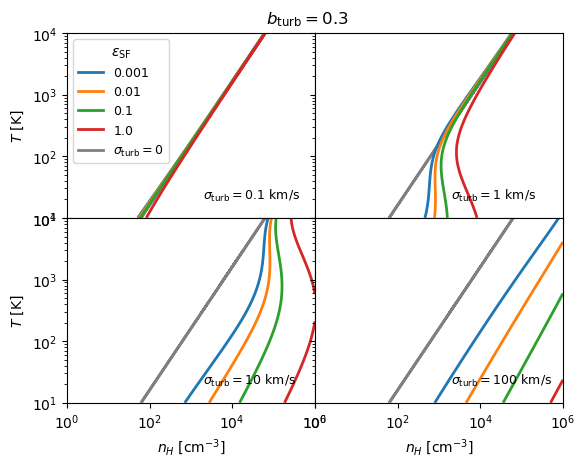

In [28]:
num = 1000
temp = 100
dx = 10 * const.pc
b_turb = 0.3
vel_turb = 100 * const.km

n_H_extrema = (1e0, 1e6)
temp_extrema = (1e1, 1e4)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
temp_1d = np.logspace(*np.log10(temp_extrema), num)
n_H, temp = np.meshgrid(n_H_1d, temp_1d, indexing='ij')
rho = n_H * const.m_p

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')

eps_sf_nodisp = calc_eps_sf2(rho, 1e-5 * const.km, temp, dx, b_turb=b_turb)

for i, vel_turb, color in zip(range(4), np.array([1e-1, 1e0, 1e1, 1e2]) * const.km, ['C0', 'C1', 'C2', 'C3']):
    ax = axs.flatten()[i]
    eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx, b_turb=b_turb)
    ax.contour(n_H, temp, eps_sf_nodisp, levels=[1e0], colors='grey', linewidths=2, linestyles='-')
    cs = ax.contour(n_H, temp, eps_sf, levels=[1e-3, 1e-2, 1e-1, 1e0], colors=['C0', 'C1', 'C2', 'C3'], linewidths=2, linestyles='-')
    #ax.clabel(cs, [1e-3, 1e-2, 1e-1, 1e0])
    ax.text(2e3, 2e1, r'$\sigma_{\rm turb} = %.3g~{\rm km/s}$' % (vel_turb / const.km), fontsize=9)
    

# cbar = plt.colorbar(im)
# cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
# cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

axs[0, 0].set_ylabel(r"$T$ [${\rm K}$]")
axs[1, 0].set_ylabel(r"$T$ [${\rm K}$]")
axs[1, 0].set_xlabel(r"$n_H$ [${\rm cm^{-3}}$]")
axs[1, 1].set_xlabel(r"$n_H$ [${\rm cm^{-3}}$]")

custom_lines = [Line2D([0], [0], color='C0', lw=2), Line2D([0], [0], color='C1', lw=2), Line2D([0], [0], color='C2', lw=2), Line2D([0], [0], color='C3', lw=2), Line2D([0], [0], color='grey', lw=2)]
axs[0, 0].legend(custom_lines, [r'$0.001$', r'$0.01$', r'$0.1$', r'$1.0$', r'$\sigma_{\rm turb} = 0$'], title=r'$\varepsilon_{\rm SF}$', loc=2, fontsize=9)

plt.suptitle(r'$b_{\rm turb} = %.2g$' % b_turb, y=0.93)

save_fig("epssf-bturb0p3")



/tmp/ipykernel_676503/3237528629.py:15: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])


Text(0.5, 1.0, '$b_{\\rm turb} = 1$')

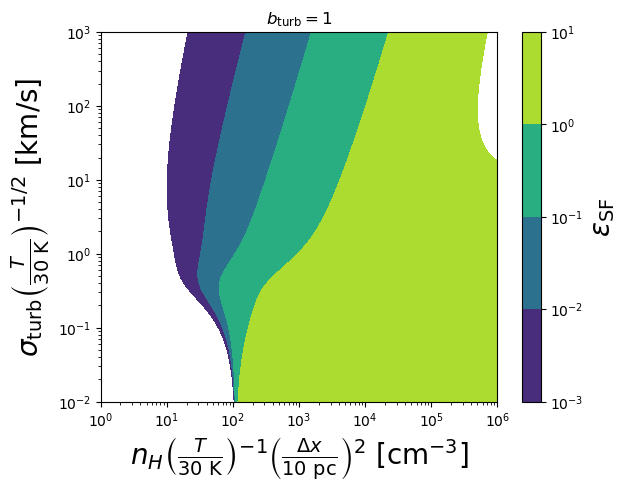

In [5]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
epsilon_SF = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("bturb0p3")



/tmp/ipykernel_3366157/1608602999.py:12: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])


Text(0, 0.5, '$\\mathcal{M}_{\\rm turb}$')

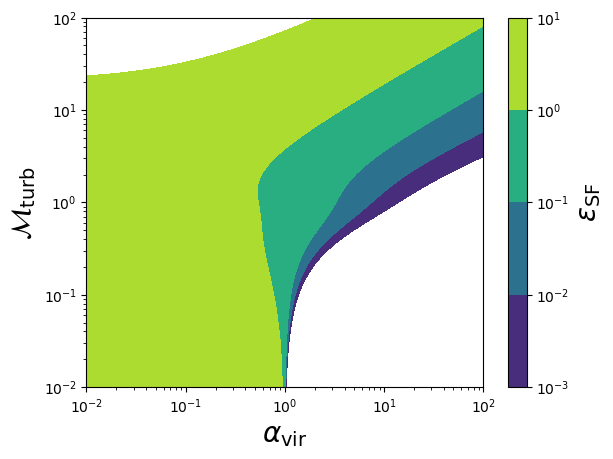

In [7]:
alpha_vir_extrema = (1e-2, 1e2)
mach_turb_extrema = (1e-2, 1e2)
num = 300
b_turb = 1.0

alpha_vir_1d = np.logspace(*np.log10(alpha_vir_extrema), num)
mach_turb_1d = np.logspace(*np.log10(mach_turb_extrema), num)
alpha_vir, mach_turb = np.meshgrid(alpha_vir_1d, mach_turb_1d, indexing='ij')
epsilon_SF = calc_epsilon_SF_old(alpha_vir, mach_turb, b_turb=b_turb)
rho_norm = (1 + mach_turb**2) / alpha_vir

im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$\alpha_{\rm vir}$", fontsize=20)
plt.ylabel(r"$\mathcal{M}_{\rm turb}$", fontsize=20)

# save_fig("SFE-alpha-mach")


/tmp/ipykernel_3366157/3765241985.py:4: RuntimeWarning: overflow encountered in exp
  return b * np.exp(-a * (1 + mach_turb)**2 / alpha_vir)


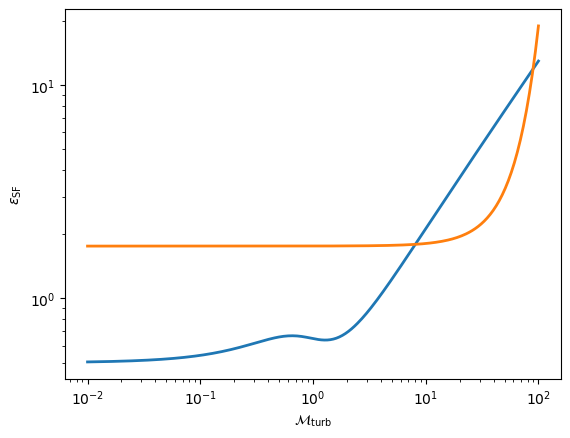

In [10]:
alpha_vir = 1

def calc_epsilon_SF_func(mach_turb, a, b):
    return b * np.exp(-a * (1 + mach_turb)**2 / alpha_vir)

epsilon_SF = calc_epsilon_SF_old(alpha_vir, mach_turb_1d, b_turb=b_turb)
popt, _ = curve_fit(calc_epsilon_SF_func, mach_turb_1d, epsilon_SF)

plt.plot(mach_turb_1d, epsilon_SF, lw=2)
plt.plot(mach_turb_1d, calc_epsilon_SF_func(mach_turb_1d, *popt), lw=2)

plt.xlabel(r'$\mathcal{M}_{\rm turb}$')
plt.ylabel(r'$\epsilon_{\rm SF}$')

plt.xscale('log')
plt.yscale('log')


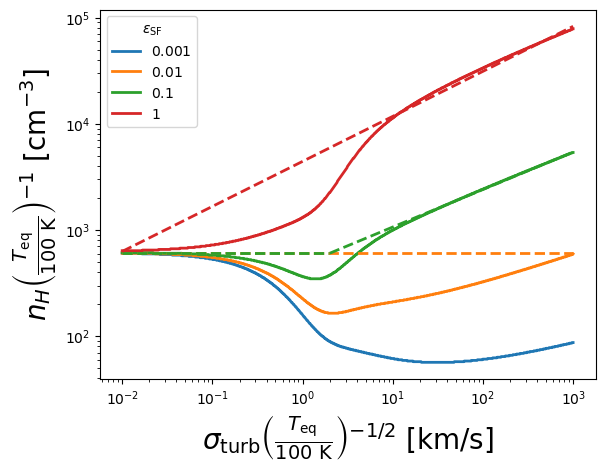

In [289]:
n_H_contour = np.zeros((4, num))

for i, epsilon_SF_contour in enumerate([1e-3, 1e-2, 1e-1, 1]):
    for j in range(num):
        if (np.max(epsilon_SF[:, j]) < epsilon_SF_contour) or (np.min(epsilon_SF[:, j]) > epsilon_SF_contour):
            n_H_contour[i, j] = n_H_contour[i, j-1]
        else:
            n_H_contour[i, j] = n_H_1d[np.argmin(np.abs(epsilon_SF[:, j] - epsilon_SF_contour))]

for i in range(4):
    SFE_str = [r'$0.001$', r'$0.01$', r'$0.1$', r'$1$'][i]
    plt.plot(vel_turb_1d / const.km, n_H_contour[i], lw=2, color='C%d' % i, label=SFE_str)
    
n_H_const = n_H_contour[0, 0]
vel_turb_cutoff = 2e0 * const.km
cutoff_idx = np.argmin(np.abs(vel_turb_1d - vel_turb_cutoff))

powerlaw = lambda x, a, b: a * x**b
powerlaw_const = lambda x, b: (n_H_const / vel_turb_cutoff**b) * x**b
popt_eps0p1, _ = curve_fit(powerlaw_const, vel_turb_1d[cutoff_idx:], n_H_contour[2][cutoff_idx:])
popt_eps1p0, _ = curve_fit(powerlaw, vel_turb_1d, n_H_contour[3])
    
plt.plot(vel_turb_1d / const.km, np.full_like(vel_turb_1d, n_H_const), lw=2, linestyle='--', color='C1')
plt.plot(vel_turb_1d[:cutoff_idx] / const.km, np.full_like(vel_turb_1d[:cutoff_idx], n_H_const), lw=2, linestyle='--', color='C2')
plt.plot(vel_turb_1d[cutoff_idx:] / const.km, powerlaw_const(vel_turb_1d[cutoff_idx:], *popt_eps0p1), lw=2, linestyle='--', color='C2')
plt.plot(vel_turb_1d / const.km, powerlaw(vel_turb_1d, *popt_eps1p0), lw=2, linestyle='--', color='C3')

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$n_H \left( \frac{T_{\rm eq}}{%d~{\rm K}} \right)^{-1}$ [${\rm cm^{-3}}$]" % temp_eq, fontsize=20)
plt.xlabel(r"$\sigma_{\rm turb} \left( \frac{T_{\rm eq}}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp_eq, fontsize=20)
plt.legend(title=r'$\varepsilon_{\rm SF}$')

#save_fig('contour-approx')


### critical halo

In [2]:
def calc_M_halo_crit(z, Sigma_crit=3e3*const.M_sol/const.pc**2, gal_to_halo=0.1):
    '''
    Critical halo mass for FFB.
    
    Args
    Sigma_crit: Critical surface density for FFB.
    '''
    Sigma_crit_comoving = Sigma_crit / (1 + z)**2
    rho_m = cosmo.rho_m(z) * (const.M_sol * cosmo.h**2 / const.kpc**3)
    R_gal = gal_to_halo * (3/(4*np.pi) / rho_m)**(1/3)
    dm_to_b = (cosmo.Om0 - cosmo.Ob0) / cosmo.Ob0
    M_halo_crit = (Sigma_crit_comoving * np.pi * R_gal**2 * dm_to_b)**3
    return M_halo_crit


In [3]:
def halo_to_stellar_mass(M_halo, z=0.):
    '''
    Halo mass as a function of stellar mass and redshift.
    
    From Girelli+2020 (https://arxiv.org/pdf/2001.02230.pdf).
    
    Args
    M_halo: halo mass in solar masses
    z: redshift
    
    Return
    M_stellar: stellar mass in solar masses
    '''
    B, mu, C, nu, D, eta, F, E = 11.83, 0.18, 0.047, -0.40, 0.728, -0.16, 0.052, 0.92
    
    M_A = 10**(B + z * mu)
    A = C * (1 + z)**mu
    gamma = D * (1 + z)**eta
    beta = F * z + E
    
    M_stellar = M_halo * 2 * A * ( (M_halo / M_A)**(-beta) + (M_halo / M_A)**gamma )**(-1)
    
    return M_stellar


def stellar_to_halo_mass(M_stellar, z=0.):
    '''
    Stellar mass as a function of halo mass and redshift.
    
    Args
    M_stellar: stellar mass in solar masses
    z: redshift
    
    Return
    M_stellar: stellar mass in solar masses
    '''
    assert M_stellar.shape == z.shape, "Stellar mass and redshift arrays must have the same shape."
    
    M_halo = np.zeros_like(M_stellar)
    
    for i, M_stellar_item in enumerate(M_stellar):
        M_halo[i] = fsolve(lambda M_halo: halo_to_stellar_mass(M_halo, z[i]) - M_stellar_item, 1e11)
    
    return M_halo


In [4]:
# Melia+2023 (https://arxiv.org/pdf/2302.10103.pdf)

JWST_names = [
    "S5-z17-1",
    "CEERS-93316",
    "S5-z12-1",
    "WHL0137-5021",
    "WHL0137-5124",
    "GLASS-z13",
    "GLASS-z12-1",
    "Maisie’s Galaxy",
    "GN-z11",
    "GLASS-z11",
    "WHL0137-3407",
    "WHL0137-5347",
    "WHL0137-5330"
]

JWST_z = np.array([16.66, 16.4, 13.72, 12.8, 12.8, 12.4, 12.22, 11.8, 11.09, 10.6, 10.5, 10.2, 10.0])
JWST_zp = np.array([1.86, 0.1, 0.86, 1.1, 1.9, 0, 0.04, 0.2, 0.08, 0, 1.0, 0.9, 1.1])
JWST_zm = np.array([0.34, 0.1, 1.92, 12.5, 12.4, 0, 0.11, 0.3, 0.12, 0, 10.5, 9.7, 7.9])

JWST_logM_stellar = np.array([8.8, 9.0, 8.1, 8.53, 8.65, 9.0, 8.6, 8.5, 9.0, 9.4, 8.78, 9.01, 8.77])
JWST_logMp_stellar = np.array([0.8, 0.4, 1.3, 0.18, 0.20, 0.3, 0.8, 0.29, 0, 0, 0.17, 0.21, 0.15])
JWST_logMm_stellar = np.array([0.5, 0.5, 0.3, 0.32, 0.30, 0.4, 0.4, 0.44, 0, 0, 0.33, 0.37, 0.26])

JWST_M = stellar_to_halo_mass(10**JWST_logM_stellar, JWST_z)
JWST_Mp = stellar_to_halo_mass(10**(JWST_logM_stellar + JWST_logMp_stellar), JWST_z) - JWST_M
JWST_Mm = JWST_M - stellar_to_halo_mass(10**(JWST_logM_stellar - JWST_logMm_stellar), JWST_z)


/usr/licensed/anaconda3/2023.3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, '$M$ [$h^{-1} M_{\\odot}$]')

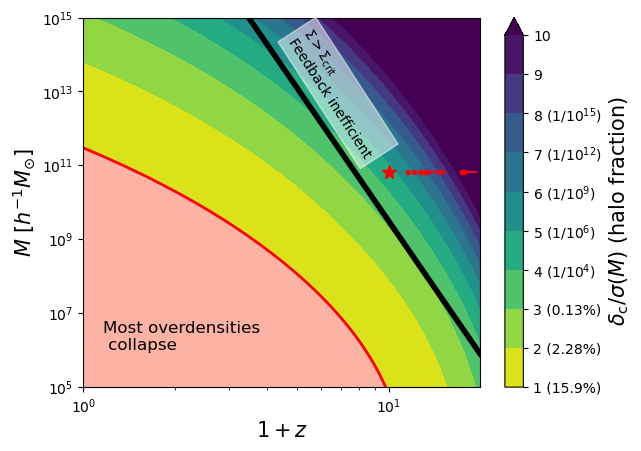

In [5]:
zp1 = np.logspace(0, 1.3, 300)
M = np.logspace(5, 15, 300)
z_grid, M_grid = np.meshgrid(zp1 - 1, M, indexing='ij')
nu = peaks.peakHeight(M_grid, z_grid)

im = plt.contourf(zp1, M, nu, levels=np.arange(1, 11, 1), cmap='viridis_r', extend='max')
plt.contour(zp1, M, nu, levels=[1], colors='red', linewidths=2)
plt.contourf(zp1, M, nu, levels=np.arange(0, 2, 1), cmap='Reds', alpha=0.5)
plt.annotate("Most overdensities\n collapse", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

M_halo_crit = calc_M_halo_crit(zp1 - 1) / (const.M_sol / cosmo.h)
plt.plot(zp1, M_halo_crit, color='black', lw=4)
plt.annotate(r"$\Sigma > \Sigma_{\rm crit}$" + "\n" + "Feedback inefficient", xy=(0.51, 0.62), xycoords='axes fraction', rotation=-57, backgroundcolor=(1, 1, 1, 0.5))

cond = (JWST_zp + JWST_zm) < 4
plt.errorbar(JWST_z[cond] + 1, JWST_M[cond] * cosmo.h, marker='.', linestyle='', color='red', yerr=(JWST_Mm[cond], JWST_Mp[cond]), xerr=(JWST_zm[cond], JWST_zp[cond]))
plt.plot(10, 1e11 * cosmo.h, marker='*', color='red', ms=10)

sigma_frac = (1 - erf(np.arange(1, 11)/np.sqrt(2))) / 2
tick_labels = ["1 (15.9%)", "2 (2.28%)", "3 (0.13%)", r"4 (1/$10^4$)", r"5 (1/$10^6$)", r"6 (1/$10^9$)", r"7 (1/$10^{12}$)", r"8 (1/$10^{15}$)", "9", "10"]

cbar = plt.colorbar(im, ticks=np.arange(1, 11))
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(label=r'$\delta_{\rm c} / \sigma(M)$ (halo fraction)', size=15)

plt.xscale('log')
plt.yscale('log')

plt.xlim(10**0, 10**1.3)
plt.ylim(1e5,1e15)

plt.xlabel(r'$1 + z$', fontsize=15)
plt.ylabel(r'$M$ [$h^{-1} M_{\odot}$]', fontsize=15)

#plt.plot(10, 1e11 * cosmo.h, 'o', color='red')

#save_fig("halos")
